In [573]:
import matplotlib.pyplot as plt
import numpy as np

In [574]:
class MembershipFunction:
    def __init__(self, name, function, based_on=[]):
        self.name = name
        self.function = function
        self.based_on = based_on
        self.input_variables = []

    def __call__(self, data:dict):
        if len(self.based_on) == 0:
            if isinstance(data, dict):
                return self.function(data[self.input_variables[0]])
            else:
                return self.function(data)
        else:
            return self.function(data)
        
    def plot(self, ax, input,xrange):
        y = [self({input: x}) for x in xrange]
        ax.plot(xrange, y, label=self.name)

        for mf in self.based_on:
            yh = [mf({input: x}) for x in xrange]
            ax.plot(xrange, yh, label=mf.name, linestyle='--', alpha=0.5, linewidth=0.5)

        ax.set_title(f"Membership Function: {self.name}")
        ax.set_xlabel(self.name)
        ax.set_ylabel("Membership Value")

        ax.legend()


    def __and__(self, other):
        return MembershipFunction(f"({self.name} and {other.name})", lambda data: min(self(data), other(data)), [ self, other])
    
    def __or__(self, other):
        return MembershipFunction(f"({self.name} or {other.name})", lambda data: max(self(data), other(data)), [ self, other])
    
    def __invert__(self):
        return MembershipFunction(f"(not {self.name})", lambda data: 1 - self(data), [ self])
    
    def __repr__(self):
        return f"MemebershipFunction({self.name})"
    
    def center_of_gravity(self, xrange):
        num = 0
        den = 0
        for x in xrange:
            y = self(x)
            num += x * y
            den += y

        if(den == 0):    
            return 0
        
        return num / den

class Triangle(MembershipFunction):

    def __init__(self, name, center, width):
        self.center = center
        self.width = width
        function = lambda x: max(0, 1 - abs(x - center) / width)
        super().__init__(name, function)

class Trapezoid(MembershipFunction):
    
        def __init__(self, name, left, center_left, center_right, right):
            self.left = left
            self.center_left = center_left
            self.center_right = center_right
            self.right = right
            function = lambda x: max(0, min((x - left) / (center_left - left), 1, (right - x) / (right - center_right)))
            super().__init__(name,function)

In [575]:
class FuzzyVariable:
    def __init__(self, name:str):
        self.name = name
        self.membership_functions: dict[str, MembershipFunction] = dict()

    def add_membership_function(self, mf: MembershipFunction):
        mf.input_variables.append(self.name)
        self.membership_functions[mf.name] = mf

    def plot(self, ax, x_range):
        for mf in self.membership_functions.values():
            mf.plot(ax, self.name, x_range)
        ax.set_title(f'Membership Functions for {self.name}')
        ax.set_xlabel(self.name)
        ax.set_ylabel('Membership Degree')
        ax.legend()

    def evaluate(self, x):
        return {name: mf(x) for name, mf in self.membership_functions.items()}
    

    def __eq__(self, name):
        return self.membership_functions[name]
    
    def __repr__(self):
        return f"FuzzyVariable({self.name}) with sets: [{', '.join(self.membership_functions)}]"

# Create Some Fuzzy Variables

In [576]:
age = FuzzyVariable("age")

age.add_membership_function(Triangle("young", 20, 22))
age.add_membership_function(Triangle("middle", 40, 15))
age.add_membership_function(Triangle("old", 60, 22))

In [577]:
height = FuzzyVariable("height")

height.add_membership_function(Trapezoid("short", 0, 140, 150, 160))
height.add_membership_function(Trapezoid("medium", 140, 160, 170, 180))
height.add_membership_function(Trapezoid("tall", 170, 180, 190, 240))

In [578]:
fitness = FuzzyVariable("fitness")

fitness.add_membership_function(Triangle("low", 0, 0.5))
fitness.add_membership_function(Trapezoid("medium", 0, 0.5, 0.7, 1))
fitness.add_membership_function(Triangle("high", 1, 0.5))

# Plot Variables

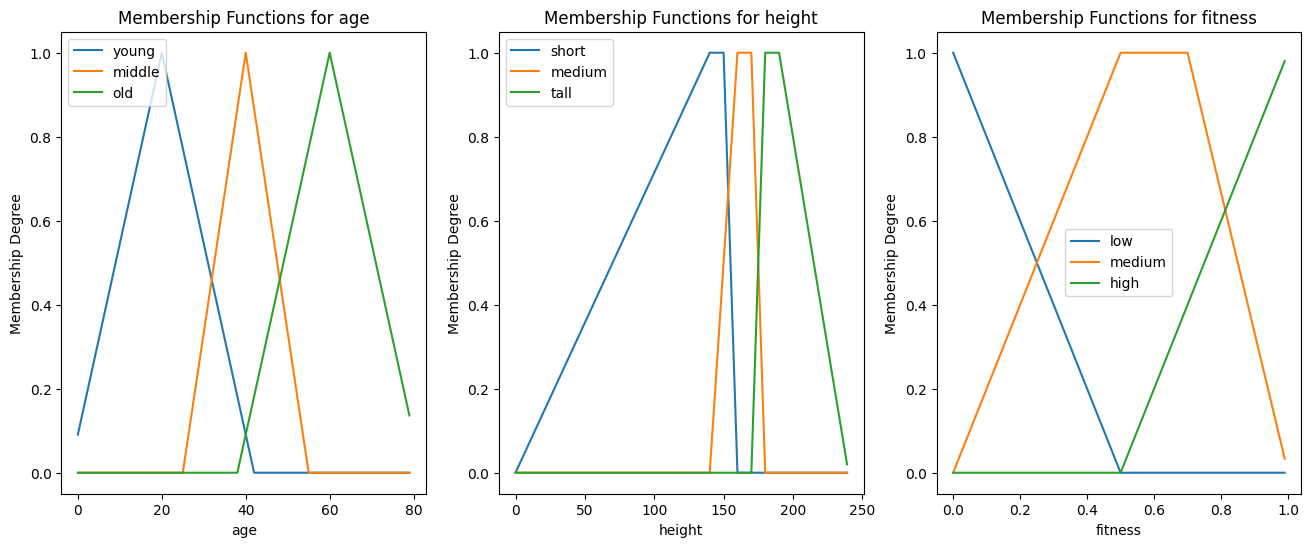

In [579]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(16, 6)

age.plot(ax[0], np.arange(0, 80, 1))
height.plot(ax[1], np.arange(0, 240, 1))
fitness.plot(ax[2], np.arange(0, 1, 0.01))

plt.show()

In [580]:
class FuzzyRule:
    def __init__(self, antecedent: MembershipFunction, consequent: MembershipFunction):
        self.antecedent = antecedent
        self.consequent = consequent


    def evaluate(self, data: dict)->MembershipFunction  :
        cut = self.antecedent(data)
        return MembershipFunction(self.consequent.name, lambda data: min(cut, self.consequent(data)), [self.consequent])


    def plot_rules(self, data):
       fig = plt.figure()
       axs = fig.subplot_mosaic([['A','B']])
       fig.set_size_inches(16, 6)

       name1,xs= data["x"]
       name2,ys = data["y"]
       
       X, Y = np.meshgrid(xs, ys)

       Z = np.array([[self.antecedent({name1: x, name2: y}) for x in xs] for y in ys])
     
       ss=axs['A'].get_subplotspec()
       axs['A'].remove()
       axs['A'] = fig.add_subplot(ss, projection='3d')
       axs['A'].plot_surface(X, Y, Z, cmap='viridis')
       axs['A'].set_title("Combination of age and height")
       axs['A'].set_xlabel("age")
       axs['A'].set_ylabel("height")
       axs['A'].set_zlabel("membership")   
       
       axs['B'].contourf(X, Y, Z, levels=10)
       axs['B'].set_title("Combination of age and height")
       axs['B'].set_xlabel("age")
       axs['B'].set_ylabel("height")
       axs['B'].legend()
       

    def __repr__(self):
        return f"FuzzyRule({self.antecedent} -> {self.consequent})"


# Plot Rule Input

In [581]:
rule1= FuzzyRule((age=="young") | (height=="short") | (age=="middle"), fitness=="low")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


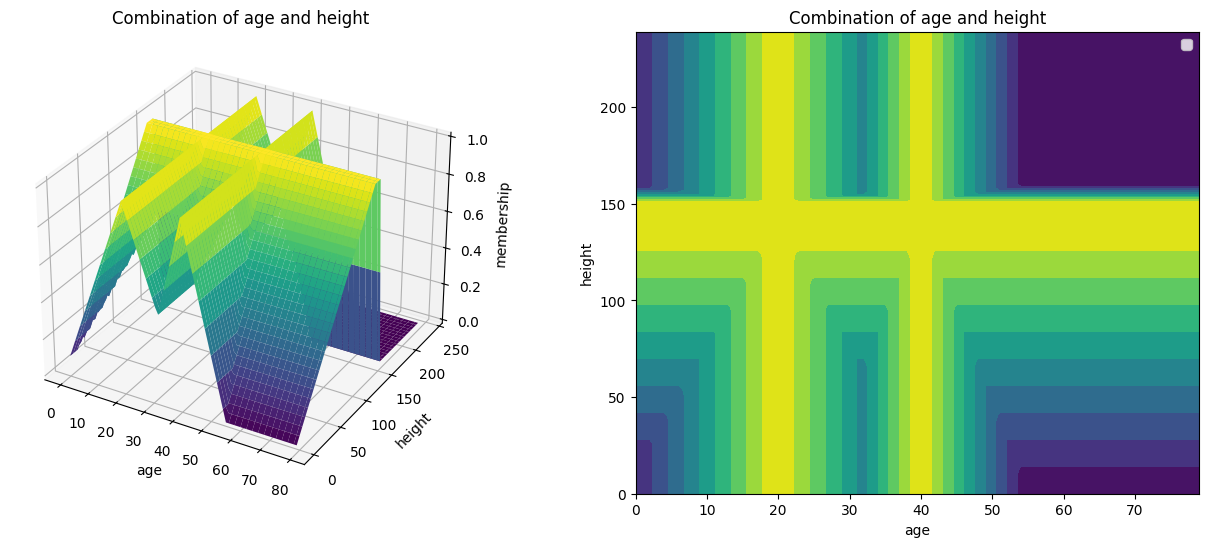

In [582]:
rule1.plot_rules({"x": ("age", np.arange(0, 80, 1)), "y": ("height", np.arange(0, 240, 1))})

In [583]:
output1=rule1.evaluate({"age": 35, "height": 75})

# Plot Cut Result Variable

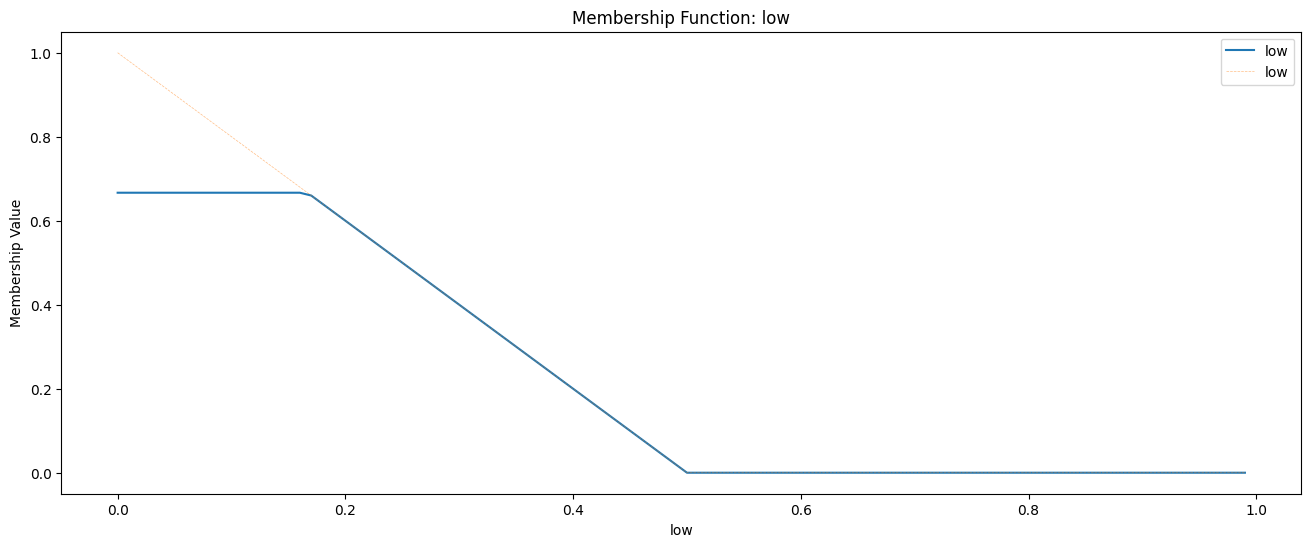

In [584]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)

output1.plot(ax, "fitness", np.arange(0, 1, 0.01))
plt.show()


In [585]:
class FuzzySystem:
    def __init__(self):
        self.rules: list[FuzzyRule] = []

    def add_rule(self, rule: FuzzyRule):
        self.rules.append(rule)

    def evaluate(self, data: dict):
        rule_results = [rule.evaluate(data) for rule in self.rules]

        input_variable_name = self.rules[0].consequent.input_variables[0]
        
        union= MembershipFunction(f"Union {input_variable_name}", lambda data: max([mf(data) for mf in rule_results]), [r.consequent for r in self.rules])
        cog = union.center_of_gravity(np.arange(0, 1, 0.05))

        return (union, cog)
    
    def plot(self, data):
        fig = plt.figure()
        axs = fig.subplot_mosaic([['A','B']])
        fig.set_size_inches(16, 6)

        name1,xs= data["x"]
        name2,ys = data["y"]

        X, Y = np.meshgrid(xs, ys)

        Z = np.array([[self.evaluate({name1: x, name2: y})[1] for x in xs] for y in ys])

        ss=axs['A'].get_subplotspec()
        axs['A'].remove()
        axs['A'] = fig.add_subplot(ss, projection='3d')
        axs['A'].plot_surface(X, Y, Z, cmap='viridis')
        axs['A'].set_title("Combination of age and height")
        axs['A'].set_xlabel("age")
        axs['A'].set_ylabel("height")
        axs['A'].set_zlabel("fitness")

        axs['B'].contourf(X, Y, Z, levels=10)
        axs['B'].set_title("Combination of age and height")
        axs['B'].set_xlabel("age")
        axs['B'].set_ylabel("height")
        axs['B'].legend()


# Resulting System

In [586]:
fs = FuzzySystem()

fs.add_rule(FuzzyRule((age=="young"), fitness=="high"))
fs.add_rule(FuzzyRule((age=="old") & (height=="tall"), fitness=="high"))
fs.add_rule(FuzzyRule((age=="middle") & (height=="medium"), fitness=="medium"))
fs.add_rule(FuzzyRule((age=="old") & (height=="short"), fitness=="low"))
fs.add_rule(FuzzyRule((age=="young") & (height=="short"), fitness=="low"))

In [587]:
(output_membership,cog) = fs.evaluate({"age": 63, "height": 140})

# Plot Fitnes at a specific point

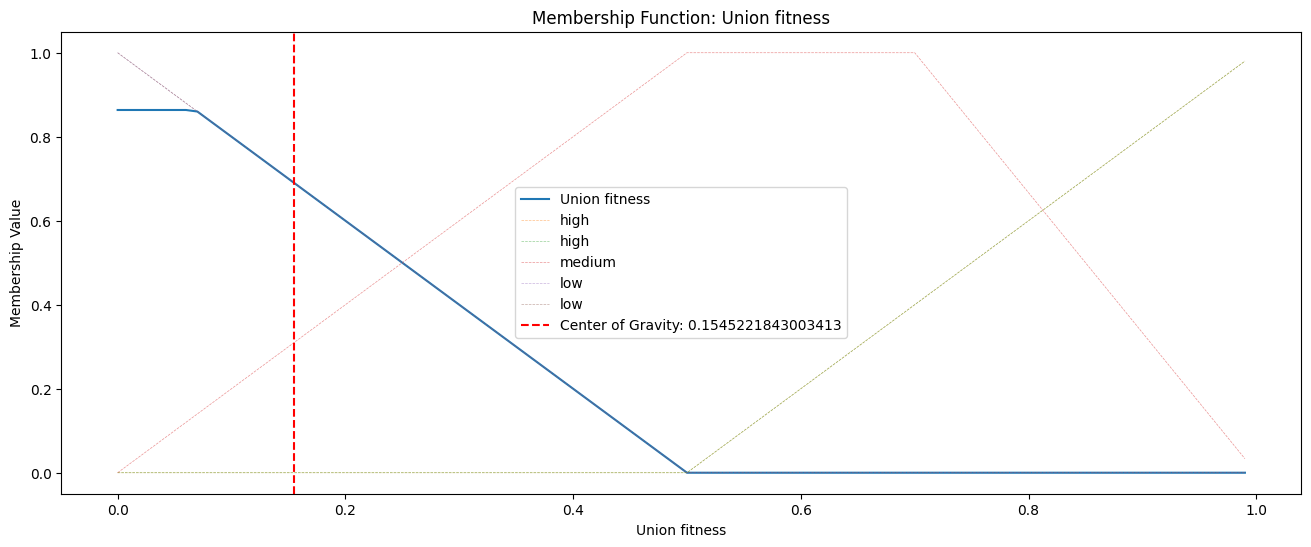

In [588]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)

output_membership.plot(ax, "fitness", np.arange(0, 1, 0.01))

ax.axvline(cog, color='red', linestyle='--', label=f"Center of Gravity: {cog}")


ax.legend()

# Plot Decision Surface

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


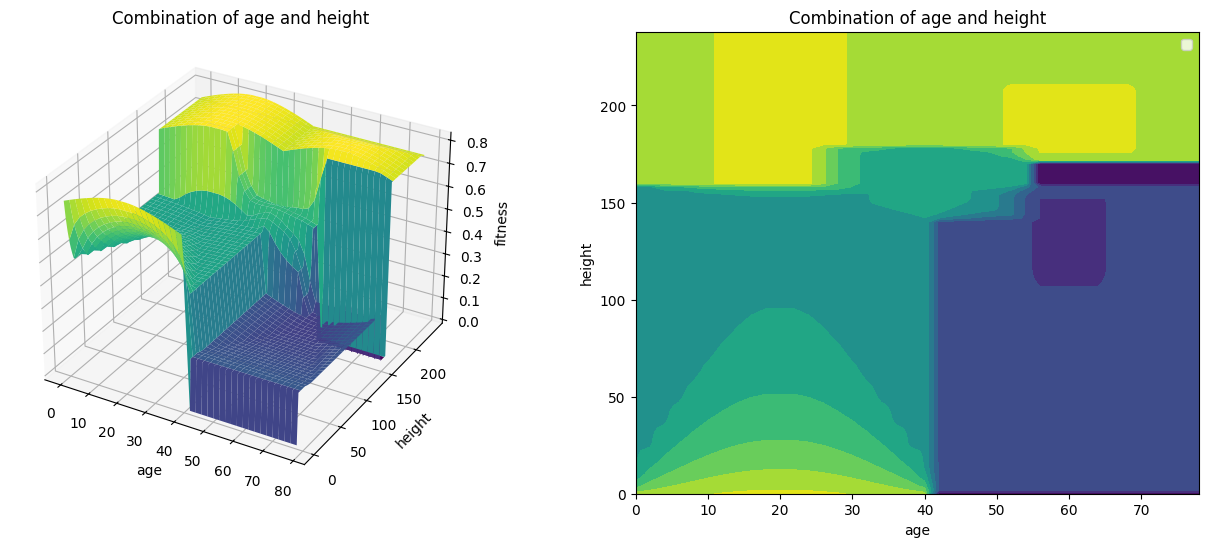

In [589]:
fs.plot({"x": ("age", np.arange(0, 80, 2)), "y": ("height", np.arange(0, 240, 2))})